In [376]:
import pandas as pd
import numpy as np
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib

from sklearn.preprocessing import MinMaxScaler
from scipy import sparse
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import pairwise_distances, cosine_distances, cosine_similarity
from scipy import spatial
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

In [377]:
music_data = pd.read_csv('../data/music_data_w_genre.csv')

In [378]:
music_data.head()

,release_date,artist,name,album,popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms_y,id,Values
0,2018-02-23,L D R U,The Calling - ORIENTAL CRAVINGS Remix,Sizzlar (Remixes),8,0.531,0.816,10,-4.240,0,0.1020,0.421,0.000321,0.475,0.310,153.974,180779,3egj44N2tiuW5F2MrqmBjW,['australian_dance']
1,2018-02-23,L D R U,The Calling - ORIENTAL CRAVINGS Remix,Sizzlar (Remixes),8,0.531,0.816,10,-4.240,0,0.1020,0.421,0.000321,0.475,0.310,153.974,180779,3egj44N2tiuW5F2MrqmBjW,['australian_dance']
2,2018-02-23,L D R U,The Calling - ORIENTAL CRAVINGS Remix,Sizzlar (Remixes),8,0.531,0.816,10,-4.240,0,0.1020,0.421,0.000321,0.475,0.310,153.974,180779,3egj44N2tiuW5F2MrqmBjW,['australian_dance']
3,2018-02-23,L D R U,The Calling - ORIENTAL CRAVINGS Remix,Sizzlar (Remixes),8,0.531,0.816,10,-4.240,0,0.1020,0.421,0.000321,0.475,0.310,153.974,180779,3egj44N2tiuW5F2MrqmBjW,['australian_dance']
4,2018-02-23,L D R U,Keeping Score (feat. Paige IV) - Paces Remix,Sizzlar (Remixes),16,0.687,0.758,5,-5.285,0,0.0564,0.109,0.000070,0.185,0.441,91.911,205000,1WAWbKpQe3XMp4b96bjazD,['australian_dance']


In [379]:
music_data['release_date']= pd.to_datetime(music_data['release_date'])
music_data['Seconds']=music_data['release_date'].map(pd.Timestamp.timestamp)

day = 60*60*24
year = 365.2425*day
music_data['year'] = np.cos(music_data['Seconds'] * (2*np.pi/year))

In [380]:
music_data.drop(columns=['duration_ms_y', 'Seconds', 'mode'], inplace = True)

In [381]:
float_cols = music_data.dtypes[music_data.dtypes == 'float64'].index.values

In [382]:
int_cols = music_data.dtypes[music_data.dtypes == 'int64'].index.values

In [383]:
music_data['Values'].head()

0    ['australian_dance']
1    ['australian_dance']
2    ['australian_dance']
3    ['australian_dance']
4    ['australian_dance']
Name: Values, dtype: object

In [384]:
def create_feature_set(df, float_cols):
    tfidf = TfidfVectorizer()
    tfidf_matrix =  tfidf.fit_transform(df['Values'])
    genre_df = pd.DataFrame(tfidf_matrix.toarray())
    genre_df.columns = [i for i in tfidf.get_feature_names()]
    genre_df.reset_index(drop = True, inplace=True)

    floats = df[float_cols].reset_index(drop = True)
    ints =  df[int_cols].reset_index(drop = True)
    pop = df[['popularity']].reset_index(drop = True)
    scaler = MinMaxScaler()
    floats_scaled = pd.DataFrame(scaler.fit_transform(floats), columns = floats.columns)
    pop_scaled = pd.DataFrame(scaler.fit_transform(pop), columns = pop.columns) 
    genre_scaled = pd.DataFrame(scaler.fit_transform(genre_df[genre_df.columns]), columns = genre_df.columns)
    ints_scaled = pd.DataFrame(scaler.fit_transform(ints), columns = ints.columns)

    final = pd.concat([floats_scaled, pop_scaled, genre_df, ints_scaled], axis = 1)
    
    final['id']=df['id'].values
    
    return final

In [385]:
features = create_feature_set(music_data, float_cols=float_cols)

In [386]:
features.head()

,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,year,...,woogie,world_devotional,world_fusion,world_worship,worship,wyoming_roots,yacht_rock,popularity,key,id
0,0.536906,0.816,0.888110,0.105590,0.422691,0.000321,0.475,0.310,0.620713,0.803729,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.084211,0.909091,3egj44N2tiuW5F2MrqmBjW
1,0.536906,0.816,0.888110,0.105590,0.422691,0.000321,0.475,0.310,0.620713,0.803729,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.084211,0.909091,3egj44N2tiuW5F2MrqmBjW
2,0.536906,0.816,0.888110,0.105590,0.422691,0.000321,0.475,0.310,0.620713,0.803729,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.084211,0.909091,3egj44N2tiuW5F2MrqmBjW
3,0.536906,0.816,0.888110,0.105590,0.422691,0.000321,0.475,0.310,0.620713,0.803729,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.084211,0.909091,3egj44N2tiuW5F2MrqmBjW
4,0.694641,0.758,0.871466,0.058385,0.109438,0.000070,0.185,0.441,0.370519,0.803729,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.168421,0.454545,1WAWbKpQe3XMp4b96bjazD


In [387]:
features.set_index('id', inplace=True)

In [388]:
def similarity(id1, id2):
    a = features.loc[[id1]]
    b = features.loc[[id2]]

    distance = spatial.distance.cosine(a[a.columns], b[b.columns])
    return distance


In [ ]:
song = input('enter song name: ')

In [ ]:
song_df = music_data[music_data['name'].str.contains(song, case=False)]

In [ ]:
if len(song_df) > 1:
    print(song_df[['id', 'name', 'artist']].head())
    song_id = input('copy and paste your id here: ')
else:
    song_id = song_df['id']

                           id  \
79851  7JLqofLzcpdjFHc6oRSBGf   
79908  5dvfYJR8yXaO9SHtqJWeL5   
79922  1MfedNodDKkvTVkNkwIBSo   
80009  08mG3Y1vljYA6bvDt4Wqkj   

                                                    name artist  
79851  Back In Black - Live at River Plate Stadium, B...  AC/DC  
79908                        Back In Black - Live - 1991  AC/DC  
79922                        Back In Black - Live - 1991  AC/DC  
80009                                      Back In Black  AC/DC  


In [ ]:
def songs(i):
    distances = {}
    for j in list(features.index):
        dist = similarity(i, j)
        distances.update({j:dist})
    return distances   

In [ ]:
my_song = songs(song_id)

In [ ]:
my_songdf = pd.DataFrame(my_song.items())
my_songdf = my_songdf.sort_values(by=1)

In [ ]:
my_songdf.head(7)

,0,1
80009,08mG3Y1vljYA6bvDt4Wqkj,0.000000
80010,2SiXAy7TuUkycRVbbWDEpo,0.017012
79966,6yl8Es1tCYD9WdSkeVLFw4,0.019485
80013,6J17MkMmuzBiIOjRH6MOBZ,0.023494
80014,2zYzyRzz6pRmhPzyfMEC8s,0.028059
80017,2j0zExWFB0PowLOeoZosjK,0.028662
80016,5xquYn2sr3uEcyuKU9BmCJ,0.030809


In [ ]:
#time to cluster
clust_1 = music_data[list(float_cols) + list(int_cols)+['id']]
clust_1.set_index('id', inplace=True)

In [ ]:
X = clust_1.copy()

sc = StandardScaler()

clust_1_sc = sc.fit_transform(X)

In [ ]:
k = 5

km = KMeans(n_clusters=k, random_state = 42)

km.fit(clust_1_sc)

KMeans(n_clusters=5, random_state=42)

In [ ]:
km.cluster_centers_

array([[-0.80080919,  0.60391772,  0.19813184, -0.09618161, -0.27802488,
        -0.26032573,  2.05929314, -0.13043615,  0.1777623 ,  0.04479694,
        -0.20588914,  0.01067072],
       [ 0.25704575,  0.22979121,  0.39058259, -0.24144013, -0.32081454,
        -0.48885389, -0.35376695,  0.24635595,  0.06130543, -0.00299831,
         0.22965118,  0.00961905],
       [-0.75599089, -1.63048133, -1.4461511 , -0.42357459,  1.77632104,
         0.33460047, -0.24868742, -0.46111492, -0.46830136,  0.2023128 ,
        -0.07453075, -0.10176064],
       [ 0.69145987, -0.27378222, -0.07319347,  2.22698242,  0.10681896,
        -0.51698795, -0.08765655,  0.3372579 , -0.1713063 , -0.15635715,
         0.14998652, -0.01614607],
       [ 0.0447401 ,  0.5341189 ,  0.03515063, -0.35651611, -0.5241436 ,
         1.78387673, -0.21707422, -0.47340606,  0.23057328, -0.1046204 ,
        -0.59185536,  0.06862859]])

In [ ]:
km.labels_

array([0, 1, 1, ..., 1, 1, 1], dtype=int32)

In [ ]:
pred = km.predict(clust_1_sc)

In [ ]:
clust_1['cluster'] = km.labels_

<ipython-input-349-614e417d8fa7>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clust_1['cluster'] = km.labels_


In [ ]:
clust_1['predictions'] = pred

<ipython-input-350-2e8836fa2abd>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clust_1['predictions'] = pred


In [ ]:
clust_1.head()

,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,year,popularity,key,cluster,predictions
id,,,,,,,,,,,,,,
3egj44N2tiuW5F2MrqmBjW,0.531,0.816,-4.240,0.1020,0.42100,0.000321,0.475,0.310,153.974,0.607458,8,10,0,0
1WAWbKpQe3XMp4b96bjazD,0.687,0.758,-5.285,0.0564,0.10900,0.000070,0.185,0.441,91.911,0.607458,16,5,1,1
1HFIgvDlSCjC95Ch6h6gF7,0.746,0.944,-5.525,0.2460,0.00208,0.341000,0.169,0.533,140.108,0.607458,11,8,1,1
0mEYJIIBcUt2GH4ftYKJ5Q,0.433,0.668,-7.694,0.0443,0.00947,0.000000,0.113,0.324,100.008,0.607458,7,6,1,1
0vQ5VW753vuqUdi4mipjVl,0.635,0.844,-6.086,0.0970,0.13700,0.331000,0.379,0.220,75.031,0.607458,7,4,4,4


In [ ]:
music_data[list(float_cols) + list(int_cols)+['id']].columns

Index(['danceability', 'energy', 'loudness', 'speechiness', 'acousticness',
       'instrumentalness', 'liveness', 'valence', 'tempo', 'year',
       'popularity', 'key', 'id'],
      dtype='object')

In [ ]:
centroids = pd.DataFrame(
sc.inverse_transform(km.cluster_centers_),
columns = list([music_data[list(float_cols) + list(int_cols)].columns]))

centroids

,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,year,popularity,key
0,0.440523,0.812463,-6.978331,0.098930,0.131244,0.096075,0.719497,0.396399,127.831854,0.162100,19.436793,5.318659
1,0.621406,0.728500,-6.123216,0.079802,0.119069,0.023046,0.170746,0.488050,124.649233,0.127740,28.024564,5.314883
2,0.448186,0.311010,-14.284365,0.055819,0.715747,0.286191,0.194642,0.315965,110.175740,0.275340,22.026854,4.914964
3,0.695686,0.615486,-8.183910,0.404837,0.240739,0.014055,0.231262,0.510161,118.292245,0.017489,26.453775,5.222371
4,0.585103,0.796799,-7.702505,0.064650,0.061218,0.749325,0.201832,0.312975,129.275112,0.054683,11.826501,5.526762


In [ ]:
silhouette_score(clust_1_sc, km.labels_)

0.1386830225794639

In [ ]:
def similarity(id1, id2):
    a = clust_1.drop(columns=['cluster', 'predictions']).loc[[id1]]
    b = clust_1.drop(columns=['cluster', 'predictions']).loc[[id2]]

    distance = spatial.distance.cosine(a[a.columns], b[b.columns])
    return distance

In [ ]:
def songs2(id):
    distances = {}
    group = clust_1.loc[clust_1['cluster'] == clust_1["cluster"].loc[id]]
    float_cols = group.dtypes[group.dtypes == 'float64'].index.values
    for i in list(group[float_cols].index):
        dist = similarity(id, i)
        distances.update({i:dist})
    return distances    

In [ ]:
rec_2 = songs2(song_id)

|Song|song_1|song_2|song_3|song_4|song_5|
|---|---|---|---|---|---|
|song_1|1.0|0.6|0.8|0.4|0.0|
|song_2|0.6|1.0|0.5|0.9|0.2|
|song_3|0.8|.5|1.0|0.7|0.7|
|song_4|0.4|0.9|0.7|1.0|0.3|
|song_5|0.0|0.2|0.7|0.3|1.0| 

In [ ]:
rec_2_df = pd.DataFrame(rec_2.items())
rec_2_df = rec_2_df.sort_values(by=1)
rec_2_df.head()

,0,1
38180,08mG3Y1vljYA6bvDt4Wqkj,0.000000
38561,6JmV5cyTQ934NxLY4Z0tg1,0.000020
25521,53SfB4huCgiRGmwzJdEo1u,0.000025
36028,6n2GPvMJtFZ4ckoc9EWHMx,0.000030
27827,02FuO3zDHGFAz0yP7HHGvy,0.000036


In [ ]:
#Code from kmeans lesson
scores = []

for k in range(2, 15):
    cl = KMeans(n_clusters=k)
    cl.fit(clust_1_sc)
    inertia = cl.inertia_
    sil = silhouette_score(clust_1_sc, cl.labels_)
    scores.append([k, inertia, sil])
    
score_df = pd.DataFrame(scores, columns = ['k', 'inertia', 'silhouette'])

In [ ]:
score_df

,k,inertia,silhouette
0,2,849443.704718,0.230347
1,3,773125.812814,0.112420
2,4,722902.293619,0.138715
3,5,679855.996506,0.138741
4,6,644514.395816,0.116021
5,7,616169.521556,0.112977
6,8,589423.533533,0.112808
7,9,568899.433449,0.113341
8,10,551726.312705,0.107734
9,11,538501.621165,0.104903


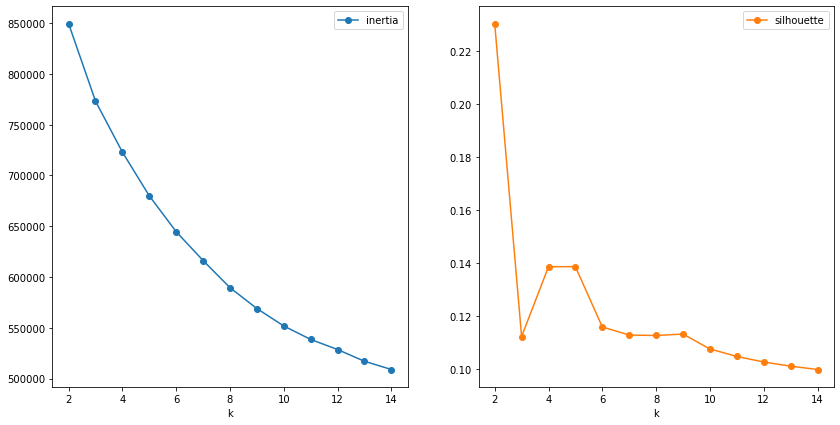

In [ ]:
axs = score_df.plot(x = 'k', subplots = True,
                   layout = (1, 2),
                   figsize = (14, 7),
                   marker = 'o')

In [ ]:
pca = PCA(n_components=2, random_state = 42)

In [ ]:
clust_2 = clust_1.drop(columns=['cluster', 'predictions'])

In [ ]:
sc.fit(clust_2)

StandardScaler()

In [ ]:
clust_2_sc = sc.transform(clust_2)

In [ ]:
pca.fit(clust_2_sc)

PCA(n_components=2, random_state=42)

In [ ]:
clust_2_pca = pca.transform(clust_2_sc)

In [ ]:
clust_2_pca.shape

(82691, 2)

In [ ]:
columns = [f'PCA_{i+1}' for i in pd.DataFrame(clust_2_pca).columns]
clust_2_df = pd.DataFrame(data = clust_2_pca, columns=columns)
clust_2_df['id'] = music_data['id']
clust_2_df.set_index('id', inplace=True)

In [ ]:
clust_2_df

,PCA_1,PCA_2
id,,
3egj44N2tiuW5F2MrqmBjW,-0.558770,-0.867979
1WAWbKpQe3XMp4b96bjazD,-0.614137,0.417167
1HFIgvDlSCjC95Ch6h6gF7,-1.551567,0.040978
0mEYJIIBcUt2GH4ftYKJ5Q,0.128048,-0.579441
0vQ5VW753vuqUdi4mipjVl,-0.114351,-0.771169
...,...,...
0nCAVzknkzRXRgB6LhRv04,-1.993636,1.272568
3iUUve7vVMnS4zHLWpv3mh,-1.068483,-0.157570
3iYPdrNM4hzxfhmMhb3UoT,0.064958,0.802424


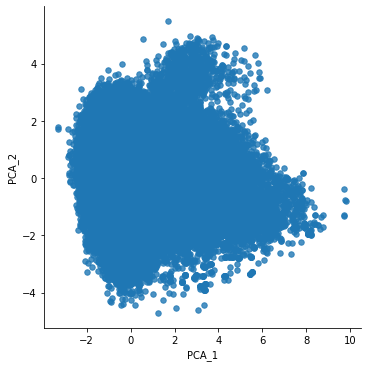

In [ ]:
sns.lmplot(
    x="PCA_1",
    y="PCA_2",
    data=clust_2_df, 
    fit_reg=False, 
    legend=True,   
    scatter_kws={"s": 30} # specify the point size
);

In [ ]:
clust_2_df

,PCA_1,PCA_2
id,,
3egj44N2tiuW5F2MrqmBjW,-0.558770,-0.867979
1WAWbKpQe3XMp4b96bjazD,-0.614137,0.417167
1HFIgvDlSCjC95Ch6h6gF7,-1.551567,0.040978
0mEYJIIBcUt2GH4ftYKJ5Q,0.128048,-0.579441
0vQ5VW753vuqUdi4mipjVl,-0.114351,-0.771169
...,...,...
0nCAVzknkzRXRgB6LhRv04,-1.993636,1.272568
3iUUve7vVMnS4zHLWpv3mh,-1.068483,-0.157570
3iYPdrNM4hzxfhmMhb3UoT,0.064958,0.802424


In [ ]:
X1 = clust_2_df.copy()

sc = StandardScaler()

X1_sc = sc.fit_transform(X1)

In [ ]:
clust_2_df

,PCA_1,PCA_2
id,,
3egj44N2tiuW5F2MrqmBjW,-0.558770,-0.867979
1WAWbKpQe3XMp4b96bjazD,-0.614137,0.417167
1HFIgvDlSCjC95Ch6h6gF7,-1.551567,0.040978
0mEYJIIBcUt2GH4ftYKJ5Q,0.128048,-0.579441
0vQ5VW753vuqUdi4mipjVl,-0.114351,-0.771169
...,...,...
0nCAVzknkzRXRgB6LhRv04,-1.993636,1.272568
3iUUve7vVMnS4zHLWpv3mh,-1.068483,-0.157570
3iYPdrNM4hzxfhmMhb3UoT,0.064958,0.802424


In [ ]:
k = 3
km = KMeans(n_clusters=k, random_state=42)
km.fit(X1_sc)

KMeans(n_clusters=3, random_state=42)

In [ ]:
km.cluster_centers_

array([[-0.31732868, -0.94027601],
       [ 1.86335633,  0.1672414 ],
       [-0.37635668,  0.70018651]])

In [ ]:
km.labels_

array([0, 2, 2, ..., 2, 2, 2], dtype=int32)

In [ ]:
pred = km.predict(X1_sc)

In [ ]:
clust_2_df['cluster'] = km.labels_
clust_2_df['predictions'] = pred

In [ ]:
clust_2_df.head()

,PCA_1,PCA_2,cluster,predictions
id,,,,
3egj44N2tiuW5F2MrqmBjW,-0.558770,-0.867979,0,0
1WAWbKpQe3XMp4b96bjazD,-0.614137,0.417167,2,2
1HFIgvDlSCjC95Ch6h6gF7,-1.551567,0.040978,2,2
0mEYJIIBcUt2GH4ftYKJ5Q,0.128048,-0.579441,0,0
0vQ5VW753vuqUdi4mipjVl,-0.114351,-0.771169,0,0


In [ ]:
centroids = pd.DataFrame(
sc.inverse_transform(km.cluster_centers_),
columns = ['PCA_1', 'PCA_2'])

centroids

,PCA_1,PCA_2
0,-0.502780,-1.225938
1,2.952326,0.218051
2,-0.596304,0.912908


<AxesSubplot:xlabel='PCA_1', ylabel='PCA_2'>

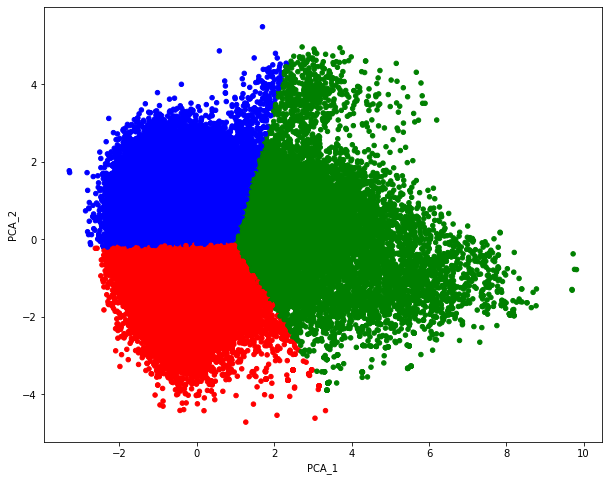

In [ ]:
color_map = {0:"red", 1:"green", 2:"blue"}
clust_2_df['color'] = clust_2_df['cluster'].map(color_map)

ax = clust_2_df.plot(    
    kind="scatter", 
    x="PCA_1",
    y="PCA_2",
    figsize=(10,8),
    c = 'color'
)

centroids.plot(
    kind="scatter", 
    x="PCA_1",
    y="PCA_2", 
    marker="*",
    c=centroids.index.map(color_map),
    s=550,
    ax=ax
)

In [ ]:
silhouette_score(X1_sc, km.labels_)

0.4085914154459091

In [ ]:
scores = []

for k in range(2, 15):
    cl = KMeans(n_clusters=k)
    cl.fit(X1_sc)
    inertia = cl.inertia_
    sil = silhouette_score(X1_sc, cl.labels_)
    scores.append([k, inertia, sil])
    
score_df = pd.DataFrame(scores, columns = ['k', 'inertia', 'silhouette'])

In [ ]:
score_df

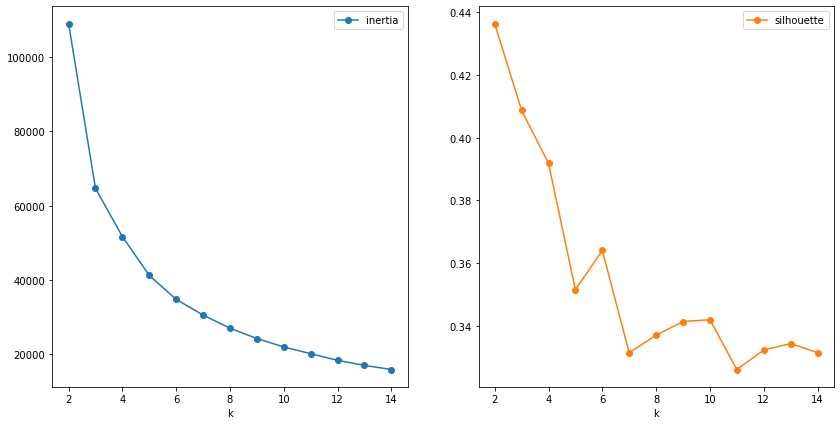

In [ ]:
axs = score_df.plot(x = 'k', subplots = True,
                   layout = (1, 2),
                   figsize = (14, 7),
                   marker = 'o')

In [ ]:
clust_2_df

,PCA_1,PCA_2,cluster,predictions,color
id,,,,,
3egj44N2tiuW5F2MrqmBjW,-0.558770,-0.867979,0,0,red
1WAWbKpQe3XMp4b96bjazD,-0.614137,0.417167,2,2,blue
1HFIgvDlSCjC95Ch6h6gF7,-1.551567,0.040978,2,2,blue
0mEYJIIBcUt2GH4ftYKJ5Q,0.128048,-0.579441,0,0,red
0vQ5VW753vuqUdi4mipjVl,-0.114351,-0.771169,0,0,red
...,...,...,...,...,...
0nCAVzknkzRXRgB6LhRv04,-1.993636,1.272568,2,2,blue
3iUUve7vVMnS4zHLWpv3mh,-1.068483,-0.157570,2,2,blue
3iYPdrNM4hzxfhmMhb3UoT,0.064958,0.802424,2,2,blue


In [ ]:
def similarity(id1, id2):
    a = clust_2_df.drop(columns=['cluster', 'predictions', 'color']).loc[[id1]]
    b = clust_2_df.drop(columns=['cluster', 'predictions', 'color']).loc[[id2]]

    distance = spatial.distance.cosine(a[a.columns], b[b.columns])
    return distance

In [ ]:
clust_2_df.drop(columns=['cluster', 'predictions', 'color']).loc[['7GWViYkd4fTS3ApKuaTLEB']]

,PCA_1,PCA_2
id,,
7GWViYkd4fTS3ApKuaTLEB,-0.121726,0.87975


In [ ]:
  def songs2(id):
    distances = {}
    group = clust_2_df.loc[clust_2_df['cluster'] == clust_2_df["cluster"].loc[id]]
    float_cols = group.dtypes[group.dtypes == 'float64'].index.values
    for i in list(group[float_cols].index):
        dist = similarity(id, i)
        distances.update({i:dist})
    return distances  

In [ ]:
clust_2_recs = songs2(song_id)

In [ ]:
clust_2_rec_df = pd.DataFrame(clust_2_recs.items())
clust_2_rec_df = clust_2_rec_df.sort_values(by=1)
clust_2_rec_df.head(20)

,0,1
37921,08mG3Y1vljYA6bvDt4Wqkj,0.000000e+00
32855,4ADRPFlyIBxRirzUJRdDLY,1.856299e-09
13462,2pKsXTkH5wsyfvsq8yH9sn,7.022370e-09
16369,3gMrOhg0iORWLrGjpHoMPt,1.137120e-08
13014,0jCmz1nJWNqcmidLl27z4t,2.131582e-08
28481,3uUJa7wv0IlJztVyA3nNXs,3.153832e-08
14305,0ea1OBAVKSKQ3qyVYhdBBX,5.978821e-08
28058,4BrzuWmOSuQuJwBaemIo12,7.861176e-08
16291,3fCh4mUqDKxHqDMNJX2Q78,8.118908e-08
16052,3ZLIgsGdXpGL0vvpnAJTfX,8.157268e-08


In [ ]:
from skimage import io
import matplotlib.pyplot as plt

def visualize_songs(df):    
    temp = df['url'].values
    plt.figure(figsize=(15,int(0.625 * len(temp))))
    columns = 5
    
    for i, url in enumerate(temp):
        plt.subplot(len(temp) / columns + 1, columns, i + 1)

        image = io.imread(url)
        plt.imshow(image)
        plt.xticks(color = 'w', fontsize = 0.1)
        plt.yticks(color = 'w', fontsize = 0.1)
        plt.xlabel(df['name'].values[i], fontsize = 12)
        plt.tight_layout(h_pad=0.4, w_pad=0)
        plt.subplots_adjust(wspace=None, hspace=None)

    plt.show()

/Users/sonnguyen/opt/anaconda3/envs/dsi-111/lib/python3.8/site-packages/skimage/io/manage_plugins.py:23: UserWarning: Your installed pillow version is < 7.1.0. Several security issues (CVE-2020-11538, CVE-2020-10379, CVE-2020-10994, CVE-2020-10177) have been fixed in pillow 7.1.0 or higher. We recommend to upgrade this library.
  from .collection import imread_collection_wrapper
